In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import norm
from scipy import signal
from matplotlib import gridspec
import matplotlib 
from open_ephys.analysis import Session
import sqlite3
import scipy
from pathlib import Path
import glob
import os
from os import listdir
import csv

sns.set(style="ticks", rc={"lines.linewidth": 5})
matplotlib.rc('xtick', labelsize=50) 
matplotlib.rc('ytick', labelsize=50) 
matplotlib.rc('axes', labelsize=50)  
matplotlib.rc('axes', titlesize=50)  
matplotlib.rc('figure', titlesize=100)
matplotlib.rc('legend', fontsize=50) 
matplotlib.rc('legend', title_fontsize=50)

In [2]:
variables = ['Goal','CurrentState','ChosenState','Distance','ChosenLocation','Choice','IsGoal']
epochs = ['ForePeriodEntry','DelayperiodEntry','DelayperiodExit','FeedbackPeriodEntry','ITIEntry']

state_dict = dict(zip(np.arange(1,14),['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C2','C3','C4']))
distance_dict = dict(zip(np.arange(1,9),np.arange(1,9)))
loc_dict = dict(zip(np.arange(200,800,200),['left','top','right']))
choice_dict = dict(zip([0,1],['Incorrect','Correct']))
goal_dict = dict(zip([0,1],['Non-Goal','Goal']))

variable_dict = pd.DataFrame(data={'col1': variables, 
                           'col2': pd.Series([state_dict,state_dict,state_dict,distance_dict,loc_dict,choice_dict,goal_dict])})

In [3]:
with open('E:/HexinData_test/Dylan_2024-03-19_14-42-22_HPC/HMaze_2024_03_19__14_44_09.eye.txt', 
          'r') as file:

    csv_reader = csv.reader(file)

    # Initialize variables to store the combined rows
    combined_rows = [np.array([]) for x in range(3)]
    current_row = []

    # Iterate through the rows
    for row_num, row in enumerate(csv_reader):
        # Join the rows every n rows
        combined_rows[row_num % 3] =  np.concatenate((combined_rows[row_num % 3], np.array(row,dtype=np.intp)))

beh = pd.read_csv('E:/HexinData_test/Dylan_2024-03-19_14-42-22_HPC/HMaze_2024_03_19__14_44_09.beh.txt', sep=",")
beh=beh[(beh.Control==0)&(beh.Choice>0)]

combined_rows = np.array(combined_rows).transpose()
combined_rows[:,0]=combined_rows[:,0]/1000-beh.GlobalStart.values[0]  # subtract global start, and change to second as unit
eyeData = pd.DataFrame(combined_rows,columns=['Time','xpos','ypos'])

# 1: bottom (goal)
# 2: center
# 3: left
# 4: top
# 5: right
eyeData['Target'] = (((eyeData.xpos.values-400)**2 + (eyeData.ypos.values-550)**2) < 65**2)*1+ \
                    (((eyeData.xpos.values-400)**2 + (eyeData.ypos.values-300)**2) < 65**2)*2+ \
                    (((eyeData.xpos.values-200)**2 + (eyeData.ypos.values-300)**2) < 65**2)*3+ \
                    (((eyeData.xpos.values-400)**2 + (eyeData.ypos.values-100)**2) < 65**2)*4+ \
                    (((eyeData.xpos.values-600)**2 + (eyeData.ypos.values-300)**2) < 65**2)*5  

ind = eyeData.Target.diff()!=0
changefixation = eyeData.loc[ind,:]
ind = changefixation.Target.values>0
targetfixation=pd.DataFrame()
targetfixation['Location'] = changefixation.Target.values[ind]
targetfixation['Start'] = changefixation.Time.values[ind]
targetfixation['End'] = changefixation.Time.values[1:][ind[:-1]]
targetfixation['Duration']=targetfixation['End']-targetfixation['Start']
targetfixation=targetfixation[targetfixation.Duration>0.1]

In [5]:
statefixation = pd.DataFrame()

for i in range(len(beh)):
    temp = targetfixation[((targetfixation.Start > beh.ForePeriodEntry.values[i]/1000)) & 
                           (targetfixation.Start < (beh.FeedbackPeriodEntry.values[i]/1000)) |
                         ((targetfixation.End > (beh.ForePeriodEntry.values[i]/1000)) & 
                           (targetfixation.End < (beh.FeedbackPeriodEntry.values[i]/1000)))].copy()
    temp = temp[temp.Location>1]
    trial_targets = beh[['TargetOne', 'TargetOneLoc','TargetTwo', 'TargetTwoLoc', 'TargetThree', 'TargetThreeLoc']].values[i]
    state = np.zeros(len(temp))
    state[temp.Location==2]=beh.CurrentState.values[i]
    
    for kk in [3,4,5]:
        state[temp.Location==kk]=trial_targets[np.where(trial_targets==(kk-2)*200)[0][0]-1]

    temp['State']=state
    statefixation = pd.concat([statefixation,temp])

statefixation = statefixation[statefixation.State>0]


In [6]:
sns.set(style="ticks", rc={"lines.linewidth": 2})
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rc('axes', labelsize=20)  
matplotlib.rc('axes', titlesize=20)  
matplotlib.rc('figure', titlesize=40)
matplotlib.rc('legend', fontsize=20) 
matplotlib.rc('legend', title_fontsize=20)

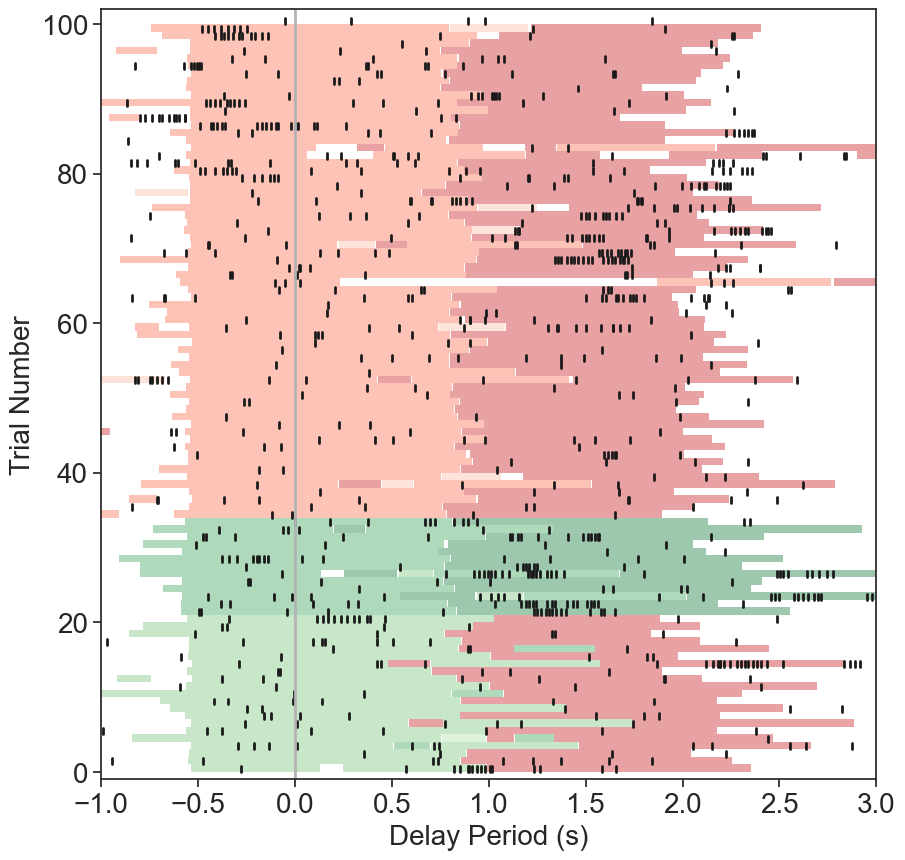

In [37]:
plt.close('all')

data = beh[(beh.Control==0) & (beh.Choice>-1) & ((beh.ChosenState==13) | (beh.ChosenState==10))].sort_values(by=['CurrentState','ChosenState']).copy()
Spikes_alinged = spikes_ts[clusters==19]-data['GlobalStart'].iloc[0]
var = 'ChosenState'

fig=plt.figure(figsize=(10,int(len(data)/10)),facecolor=(1, 1, 1))
colors = list(sns.color_palette('Purples',5))+list(sns.color_palette('Greens',5))+list(sns.color_palette('Reds',3))

fore_onset = data['ForePeriodEntry'].to_numpy()/1000
delay_onet = data['DelayperiodEntry'].to_numpy()/1000
fb_onset = data['FeedbackPeriodEntry'].to_numpy()/1000

for trial in range(len(data)): 
    
    ind = (Spikes_alinged>fore_onset[trial]) & (Spikes_alinged<(fb_onset[trial]+1))
    trial_spike=Spikes_alinged[ind]-delay_onet[trial]
    plt.plot([trial_spike,trial_spike],[trial,trial+0.8],'k-')
    
    temp = targetfixation[((targetfixation.Start > fore_onset[trial]) & 
                           (targetfixation.Start < fb_onset[trial])) |
                         ((targetfixation.End > fore_onset[trial]) & 
                           (targetfixation.End < fb_onset[trial]))].copy()
    
    trial_targets = data[['CurrentState','TargetOne', 'TargetOneLoc','TargetTwo', 'TargetTwoLoc', 'TargetThree', 'TargetThreeLoc']].values[trial]
    
    for jj in range(len(temp)):
    
        fixationloc = temp.Location.values[jj]
        if fixationloc>1:
            if fixationloc==2:
                state=trial_targets[0]
            else:
                state=trial_targets[np.where(trial_targets==(fixationloc-2)*200)[0][0]-1]
                
            plt.fill_between([temp.Start.values[jj],temp.End.values[jj]]-delay_onet[trial],
                            trial,trial+1,color=colors[state-1],alpha=0.4,edgecolor='none')

plt.plot([0,0],[-1,len(data)+1],color=[0.7,0.7,0.7])
plt.xlabel('Delay Period (s)')
plt.ylabel('Trial Number')
plt.xlim(-1,3)
plt.ylim(-1,len(data)+1)
plt.savefig(str(DATA_DIRECTORY) + '/Neuron#6_'+var+'fixationcolored_delay.png', orientation = 'portrait', format = 'png')

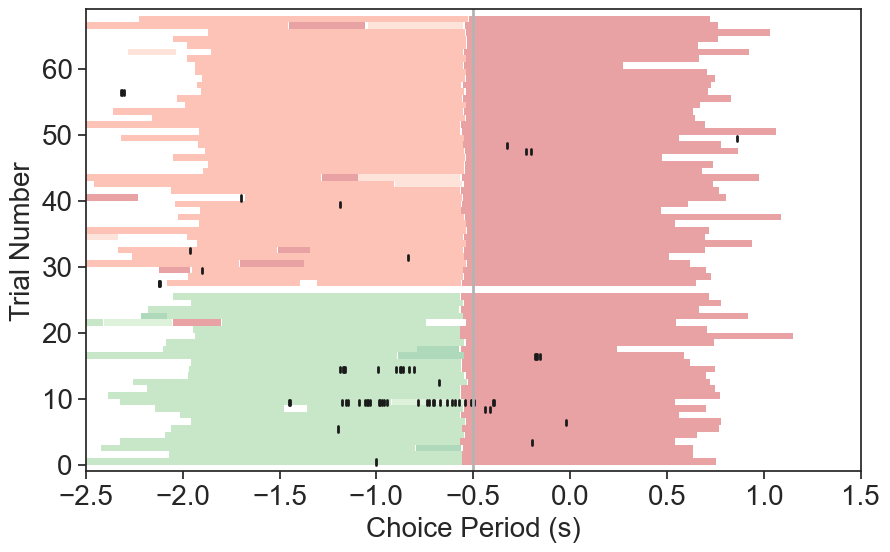

In [52]:
plt.close('all')

data = beh[(beh.Control==0) & (beh.Choice>-1) & ((beh.ChosenState==13))].sort_values(by=['CurrentState','ChosenState']).copy()
Spikes_alinged = spikes_ts[clusters==19]-data['GlobalStart'].iloc[0]
var = 'ChosenState'

fig=plt.figure(figsize=(10,int(len(data)/10)),facecolor=(1, 1, 1))
colors = list(sns.color_palette('Purples',5))+list(sns.color_palette('Greens',5))+list(sns.color_palette('Reds',3))

fore_onset = data['ForePeriodEntry'].to_numpy()/1000
delay_onet = data['DelayperiodEntry'].to_numpy()/1000
fb_onset = data['FeedbackPeriodEntry'].to_numpy()/1000

for trial in range(len(data)): 
    
    ind = (Spikes_alinged>fore_onset[trial]) & (Spikes_alinged<(fb_onset[trial]+1))
    trial_spike=Spikes_alinged[ind]-fb_onset[trial]
    plt.plot([trial_spike,trial_spike],[trial,trial+0.8],'k-')
    
    temp = targetfixation[((targetfixation.Start > fore_onset[trial]) & 
                           (targetfixation.Start < fb_onset[trial])) |
                         ((targetfixation.End > fore_onset[trial]) & 
                           (targetfixation.End < fb_onset[trial]))].copy()
    
    trial_targets = data[['CurrentState','TargetOne', 'TargetOneLoc','TargetTwo', 'TargetTwoLoc', 'TargetThree', 'TargetThreeLoc']].values[trial]
    
    for jj in range(len(temp)):
    
        fixationloc = temp.Location.values[jj]
        if fixationloc>1:
            if fixationloc==2:
                state=trial_targets[0]
            else:
                state=trial_targets[np.where(trial_targets==(fixationloc-2)*200)[0][0]-1]
                
            plt.fill_between([temp.Start.values[jj],temp.End.values[jj]]-fb_onset[trial],
                            trial,trial+1,color=colors[state-1],alpha=0.4,edgecolor='none')

plt.plot([-0.5,-0.5],[-1,len(data)+1],color=[0.7,0.7,0.7])
plt.xlabel('Choice Period (s)')
plt.ylabel('Trial Number')
plt.xlim(-2.5,1.5)
plt.ylim(-1,len(data)+1)
plt.savefig(str(DATA_DIRECTORY) + '/Neuron#19_'+var+'fixationcolored_state13.png', orientation = 'portrait', format = 'png')

In [ ]:
plt.close('all')
fig=plt.figure(figsize=(10,30),facecolor=(1, 1, 1))
colors = list(sns.color_palette('Purples',5))+list(sns.color_palette('Greens',5))+list(sns.color_palette('Reds',3))

start_time = statefixation.Start.values
end_time = statefixation.End.values
Spikes_alinged = spikes_ts[clusters==6]-beh['GlobalStart'].iloc[0]
var='chosenstate'
var_values = statefixation.State.to_numpy()
uni_var_values = np.unique(var_values)
spikes_sorted = [[] for x in range(len(uni_var_values))]

for trial in range(len(statefixation)): 
    ind = (Spikes_alinged>start_time[trial]-2) & (Spikes_alinged<(end_time[trial]+0.5))
    trial_spike=Spikes_alinged[ind]-start_time[trial]
    index=np.where(var_values[trial]==uni_var_values)[0][0]
    spikes_sorted[index].append(trial_spike)

total_trial=0
for ii,vv in enumerate(uni_var_values):

    curr_spikes = spikes_sorted[ii]
    n_trial = len(curr_spikes)

    for tt in range(n_trial):
        if len(curr_spikes[tt])>0:
            plt.plot([curr_spikes[tt],curr_spikes[tt]],[tt+total_trial,tt+total_trial+0.8],'k-')

    plt.fill_between([0,1],[total_trial,total_trial],[total_trial+n_trial,total_trial+n_trial],
                             alpha=0.4,color=colors[int(vv-1)])            

    total_trial=total_trial+n_trial

# ax.plot([0,0],ax.get_ylim(),color=[0.5,0.5,0.5])
    
# ax.set_xlim(-0.5,1)
# ax.set_xticks([])
plt.savefig(str(DATA_DIRECTORY) + '/Neuron#6_'+var+'fixation.png', orientation = 'portrait', format = 'png')

In [10]:
np.savez('0328',clusters,spikes_ts,beh)

E:\HexinData_test\Dylan_2024-03-28_14-32-11_HPC
Neuron 0
Neuron 1
Neuron 2
Neuron 3
Neuron 4
Neuron 5
Neuron 6
Neuron 7
Neuron 8
Neuron 9
Neuron 10
Neuron 11
Neuron 12
Neuron 13
Neuron 14
Neuron 15
Neuron 16
Neuron 17
Neuron 18
Neuron 19
Neuron 20
Neuron 21
Neuron 22
Neuron 23
Neuron 24
Neuron 25
Neuron 26
Neuron 27
Neuron 28
Neuron 29
Neuron 30
Neuron 31
Neuron 32
Neuron 33
Neuron 34
Neuron 35
Neuron 36
Neuron 37
Neuron 38
Neuron 39
Neuron 40
Neuron 41
Neuron 42
Neuron 43
Neuron 44
Neuron 45
Neuron 46
Neuron 47
Neuron 48
Neuron 49
Neuron 50
Neuron 51
Neuron 52
Neuron 53
Neuron 54
Neuron 55
Neuron 56
Neuron 57
Neuron 58
Neuron 59
Neuron 60
Neuron 61
Neuron 62
Neuron 63
Neuron 64
Neuron 65
Neuron 66
Neuron 67
Neuron 68
Neuron 69


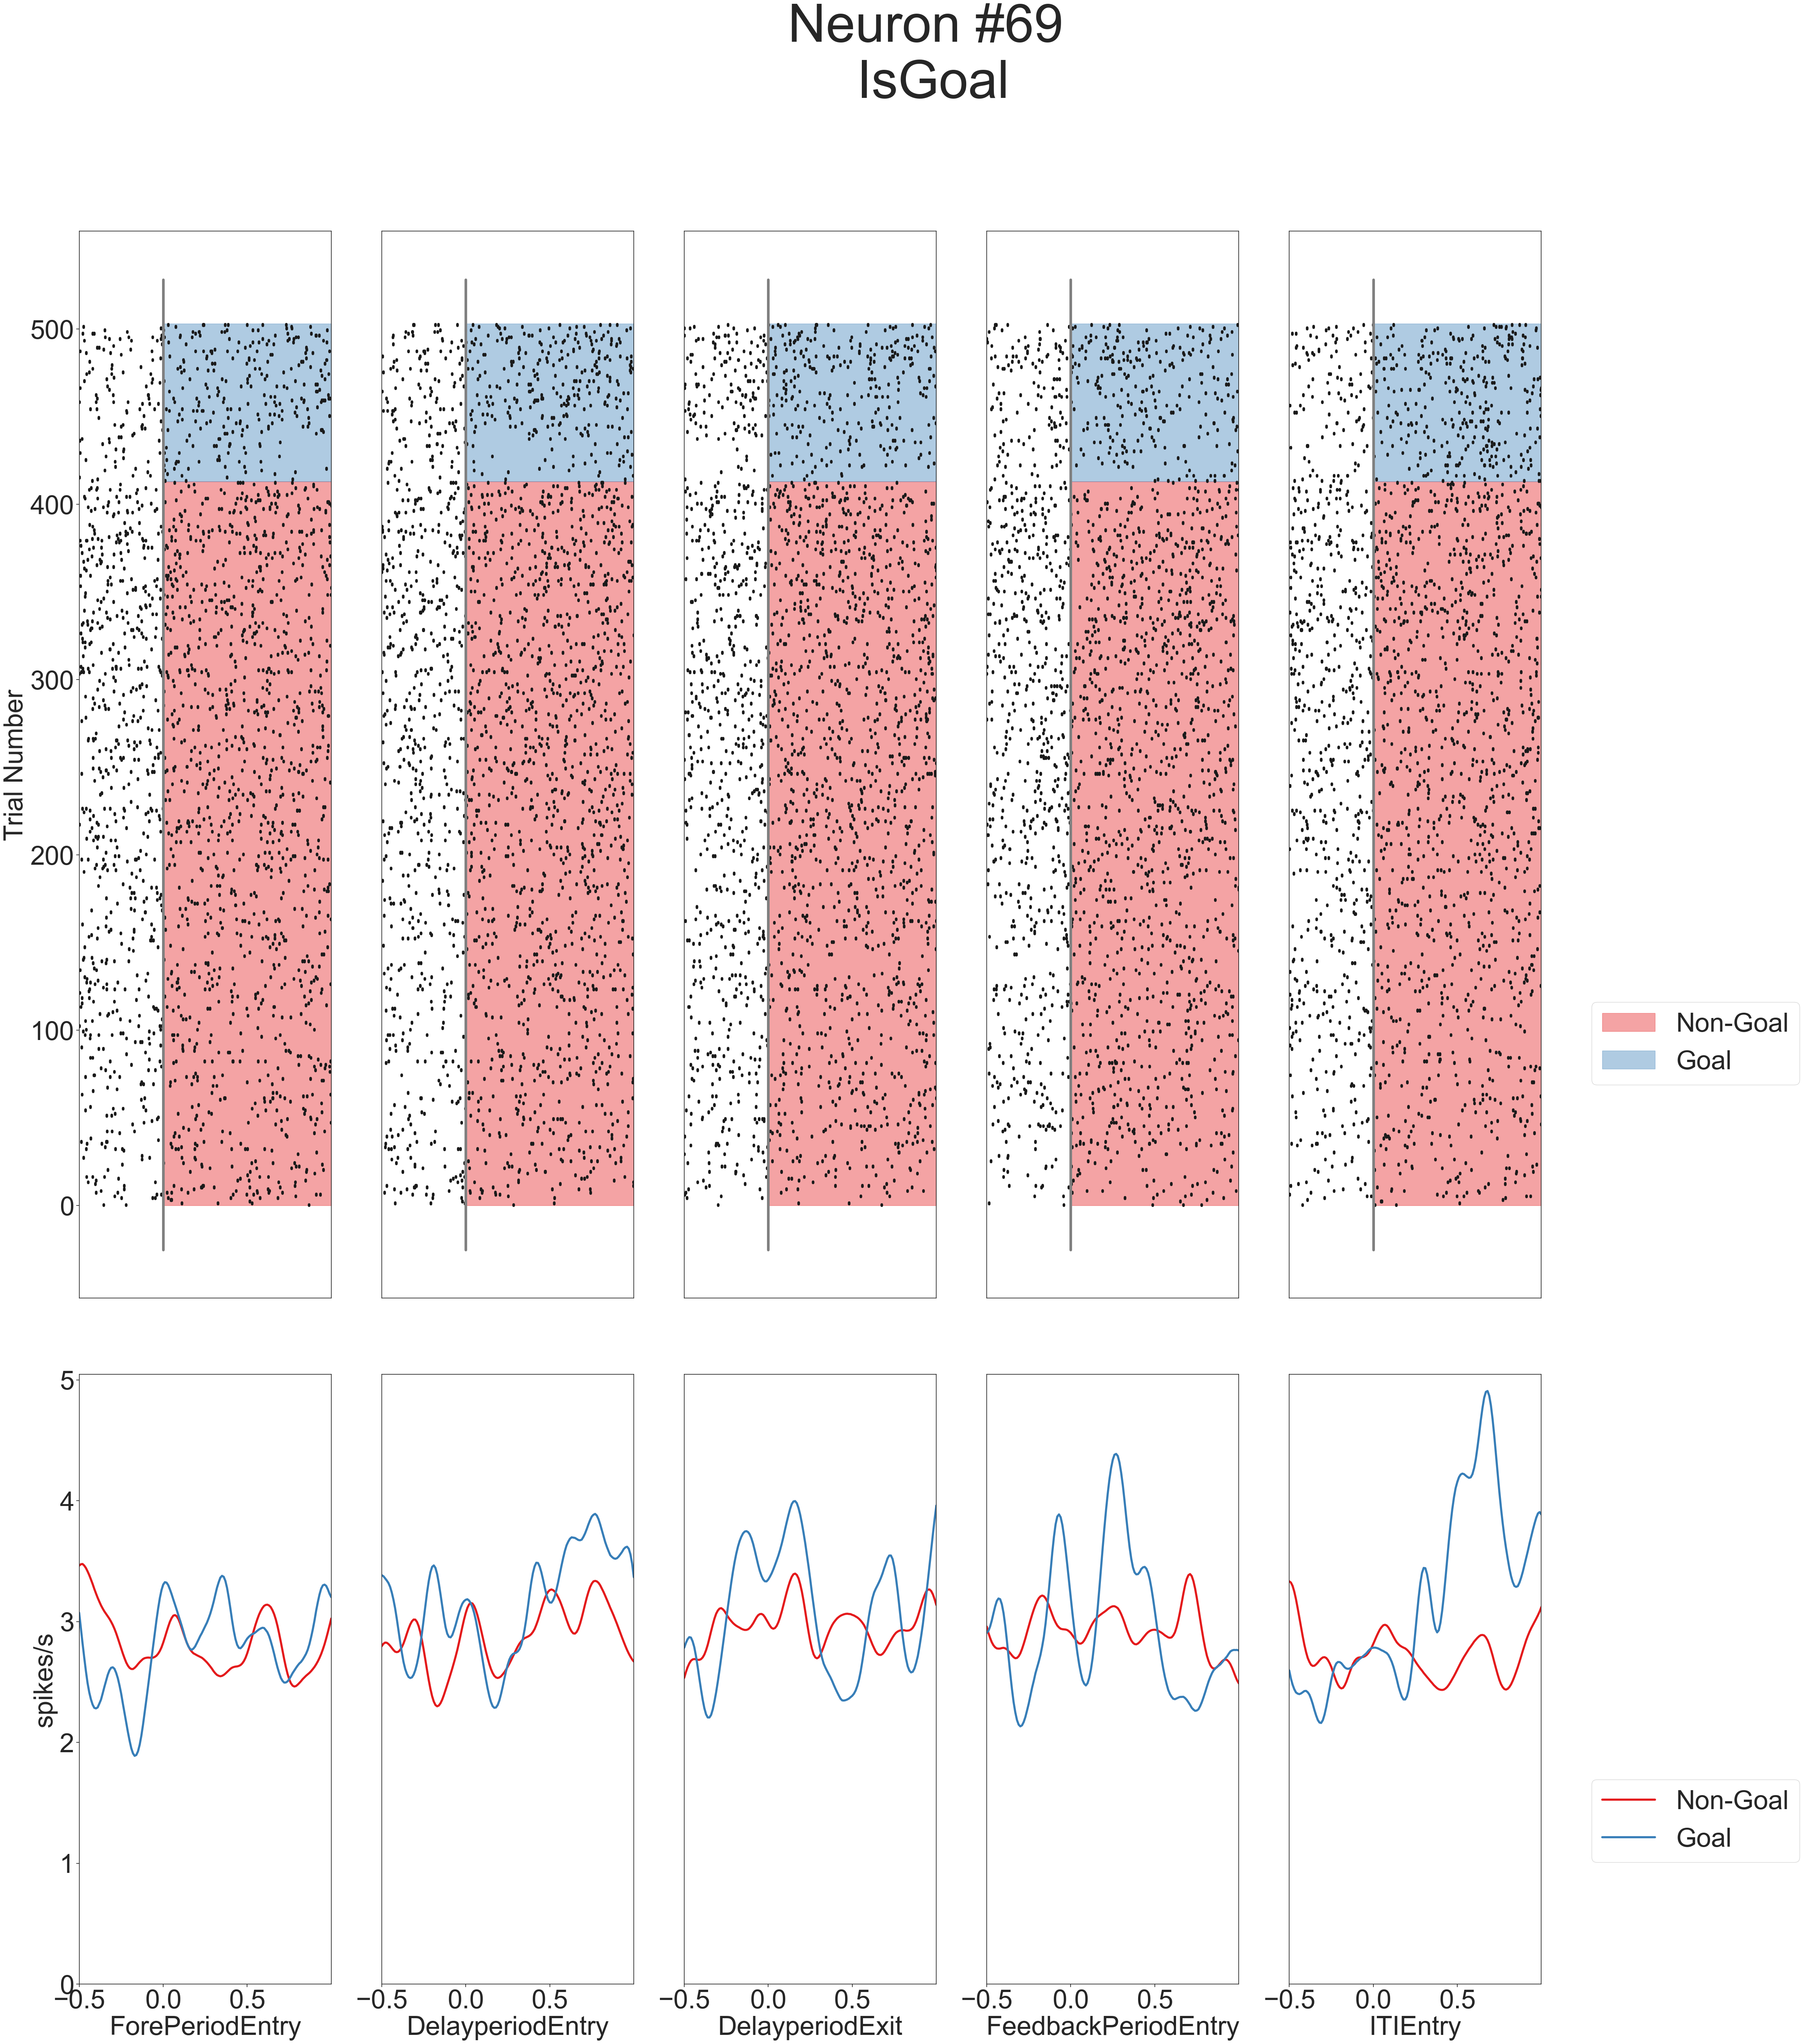

In [7]:
mypath = Path('E:/HexinData_test')
for ii,f in enumerate(listdir(mypath)):
    if ii==7:
        DATA_DIRECTORY = mypath / f
        print(DATA_DIRECTORY)
        clusters,spikes_ts,beh = load_data(DATA_DIRECTORY)
        plot_session_neuron(DATA_DIRECTORY,clusters,spikes_ts,beh)

E:\HexinData_test\Dylan_2024-08-14_16-57-15_HPC
Neuron 0
Neuron 1
Neuron 2
Neuron 3
Neuron 4
Neuron 5
Neuron 6
Neuron 7
Neuron 8
Neuron 9
Neuron 10
Neuron 11
Neuron 12
Neuron 13
Neuron 14
Neuron 15
Neuron 16
Neuron 17
Neuron 18
Neuron 19
Neuron 20
Neuron 21
Neuron 22
Neuron 23
Neuron 24
Neuron 25
Neuron 26
Neuron 27
Neuron 28
Neuron 29
Neuron 30
Neuron 31
Neuron 32
Neuron 33
Neuron 34
Neuron 35
Neuron 36
Neuron 37
Neuron 38
Neuron 39
Neuron 40
Neuron 41
Neuron 42


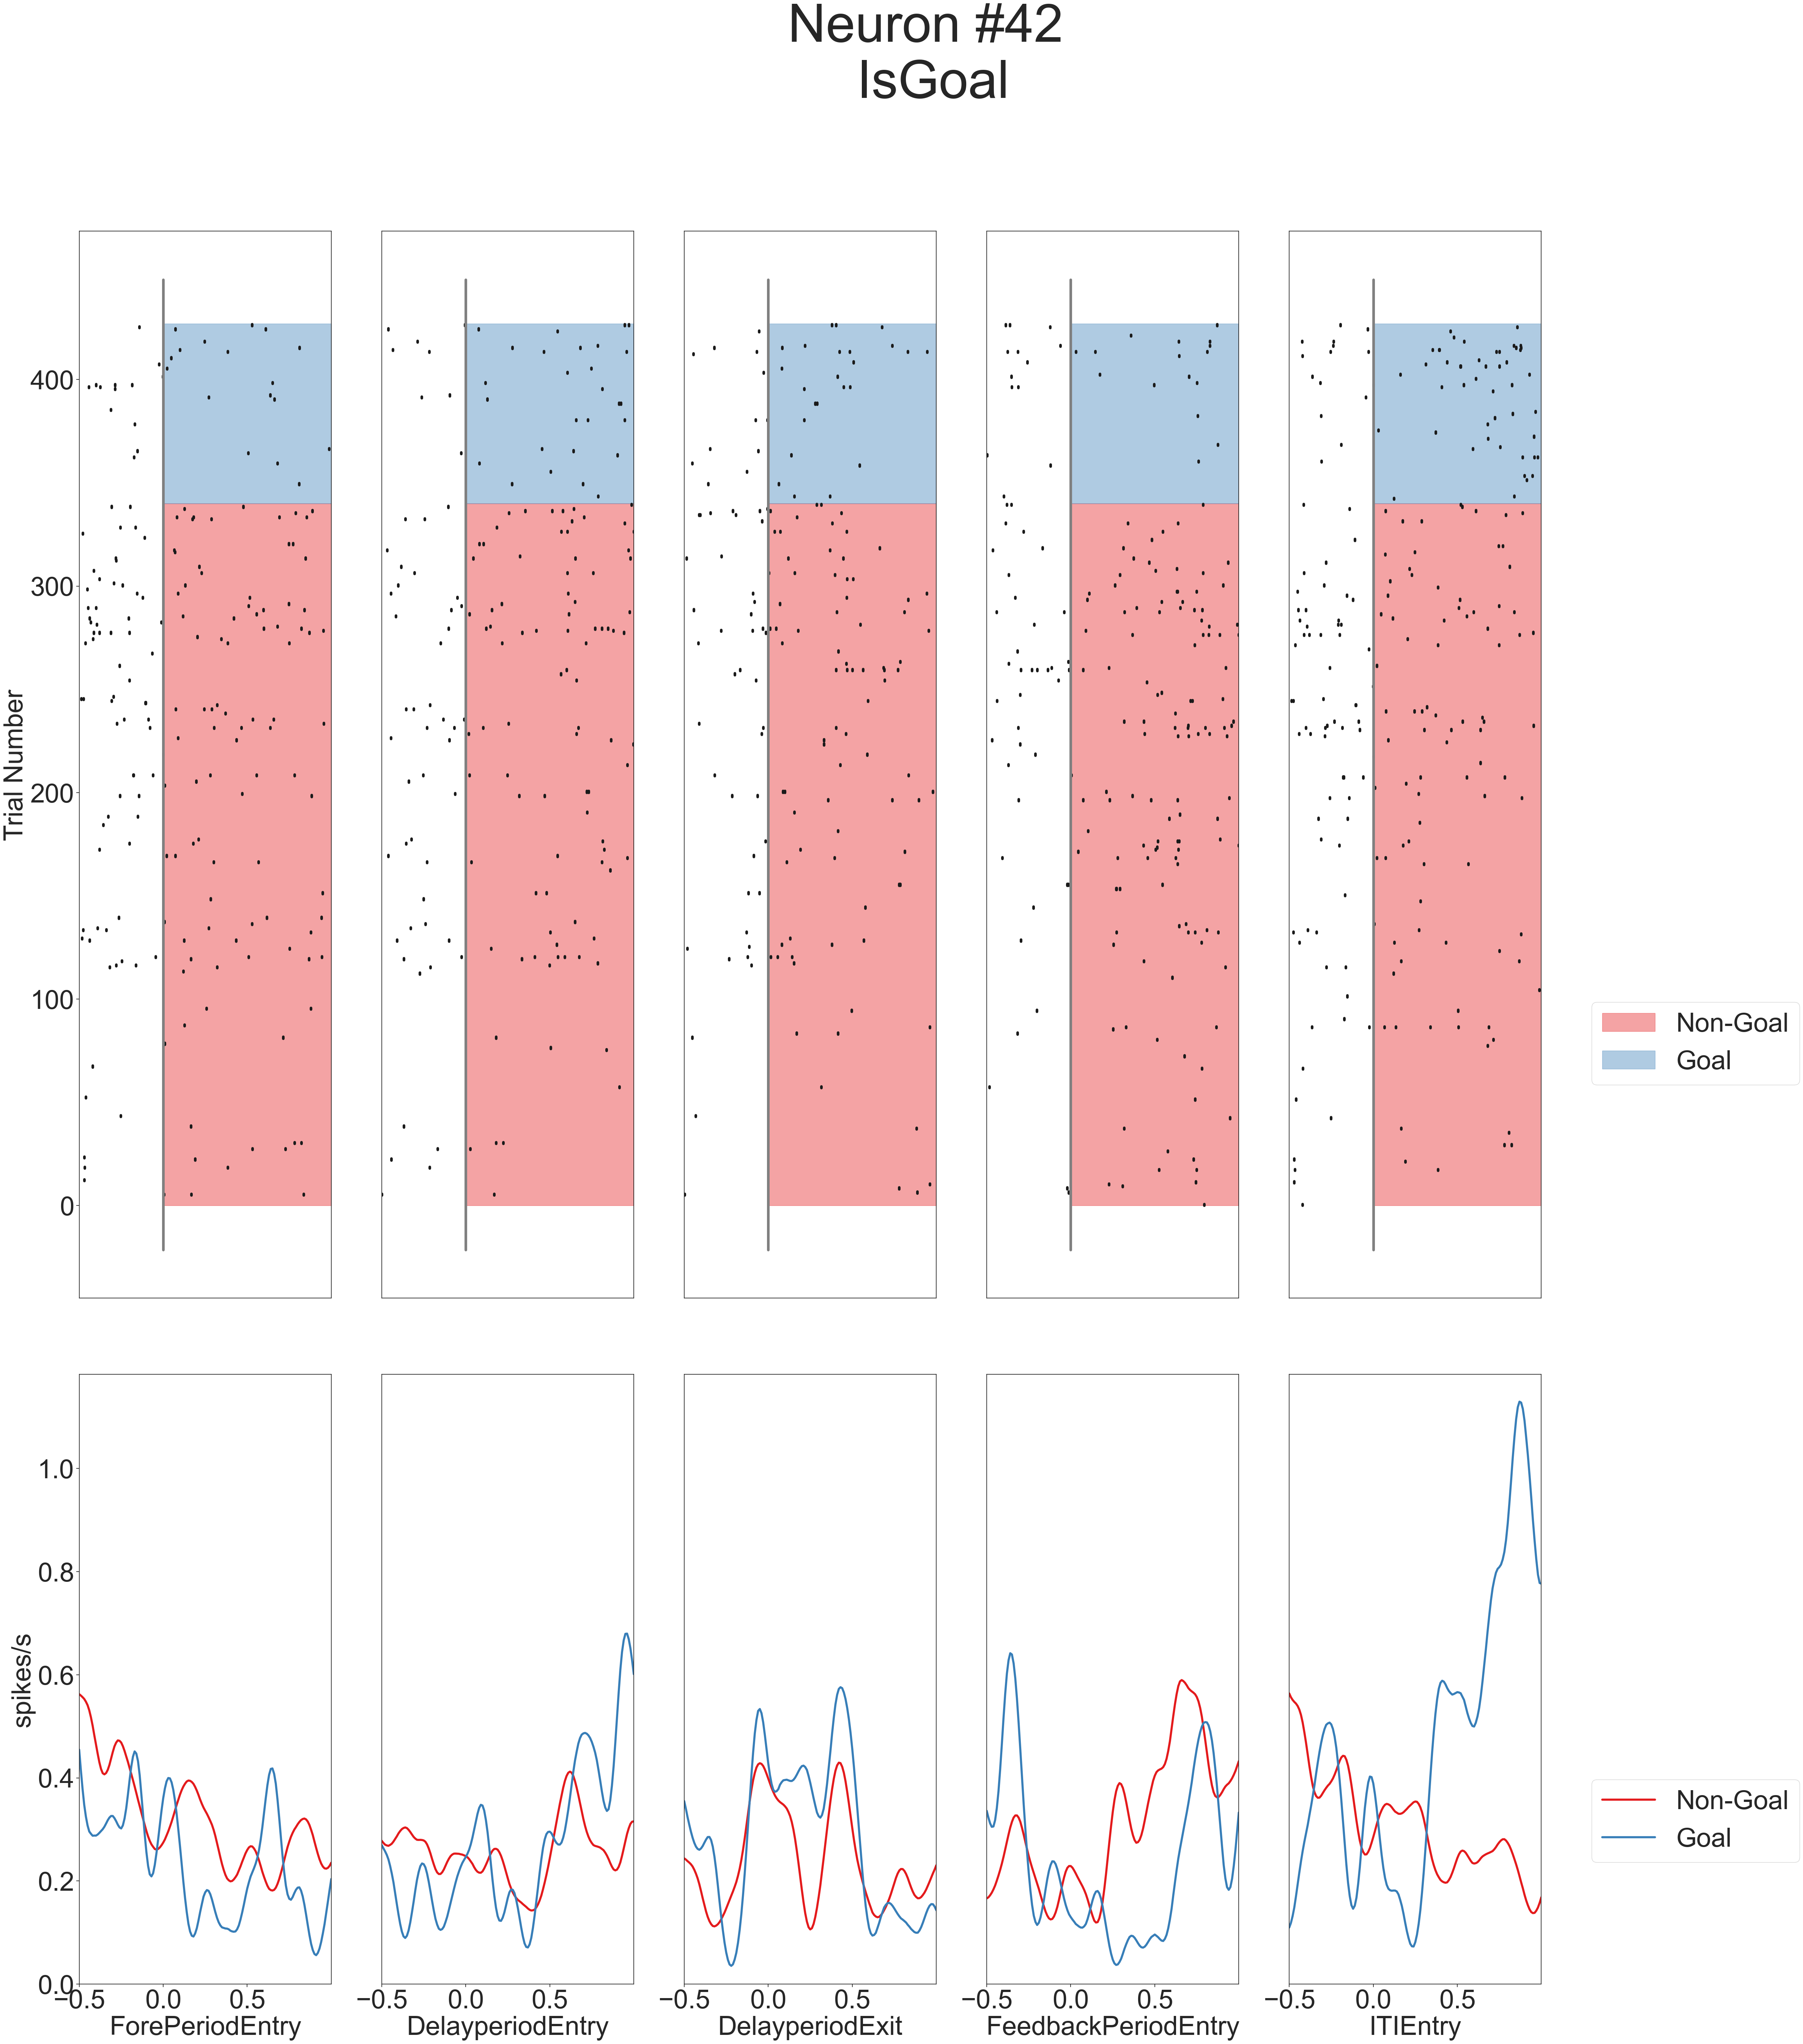

In [10]:
mypath = Path('E:/HexinData_test')
for ii,f in enumerate(listdir(mypath)):
    if ii==26:
        DATA_DIRECTORY = mypath / f
        print(DATA_DIRECTORY)
        clusters,spikes_ts,beh = load_data(DATA_DIRECTORY)
        plot_session_neuron(DATA_DIRECTORY,clusters,spikes_ts,beh)

In [3]:
def plot_session_neuron(DATA_DIRECTORY,clusters,spikes_ts,beh):

    for cellid in np.unique(clusters):


        print('Neuron ' + str(cellid))
        
        cell_spikes = spikes_ts[clusters==cellid]
        
        for var in variables:
            
            y_max=0
            colors = sns.color_palette('Set1')
                
            if var=='Goal' or var=='CurrentState' or var=='ChosenState':
                colors = list(sns.color_palette('Purples',5))+list(sns.color_palette('Greens',5))+list(sns.color_palette('Reds',3))
            
            if var=='Distance':
                colors = sns.color_palette('Purples_r',8)
        
            keys = np.array(list(variable_dict[variable_dict.col1==var].col2.values[0].keys()))
                
            plt.close('all')
            fig=plt.figure(figsize=(60,60),facecolor=(1, 1, 1))
            gs = gridspec.GridSpec(8, 6,wspace=0.2,hspace=0.5) 
        
            for ii, epoch in enumerate(epochs):
            
                ax = plt.subplot(gs[:5,ii])
                lgd_val = plot_aligned_spikes(beh[(beh.Control==0) & (beh.Choice>-1)],cell_spikes,epoch,var,ax,colors,keys)
                
                if ii==0:
                    ax.set_ylabel('Trial Number')
                else:
                    ax.set_ylabel('')
                    ax.set_yticks([])
        
                if ii==4:
                    for vv in lgd_val:
                        color_ind = np.where(keys==vv)[0][0]
                        ax.fill_between([0,0],[0,0],alpha=0.4,color=colors[color_ind],
                                        label=variable_dict[variable_dict.col1==var].col2.values[0].get(vv))
                    ax.legend(loc=(1.2,0.2))
        
        
                ax = plt.subplot(gs[5:,ii])
                lgd_val = plot_aligned_sdf(beh[(beh.Control==0) & (beh.Choice>-1)],cell_spikes,epoch,var,ax,colors,keys)
                y_max=np.max((ax.get_ylim()[1],y_max))
                ax.set_xlabel(epoch)
                ax.set_xlim(-0.5,1)
                ax.set_xticks([-0.5,0,0.5])
                    
                if ii==0:
                    ax.set_ylabel('spikes/s')
                else:
                    ax.set_ylabel('')
                    ax.set_yticks([])
                    
                if ii==4:
                    ncol=1
                    if len(beh[var].unique())>6:
                        ncol=2
                    ax.legend([variable_dict[variable_dict.col1==var].col2.values[0].get(key) for key in lgd_val],
                              loc=(1.2,0.2),ncol=ncol)

            for ii, epoch in enumerate(epochs):
                ax = plt.subplot(gs[5:,ii])
                ax.set_ylim(0,y_max)
                ax.plot([0,0],[y_max,y_max],color=[0.5,0.5,0.5])
                
            
            plt.suptitle('Neuron #'+str(cellid)+' \n'+var)
            
            plt.savefig(str(DATA_DIRECTORY) + '/Neuron'+str(cellid)+'_'+var+'.png', orientation = 'portrait', format = 'png')

In [4]:
def plot_aligned_sdf(data,Spikes_alinged,epoch,var,ax,colors,keys,window=[-0.5,1],sigma=50,step=10):
    
    timestamps = data[epoch].to_numpy().astype(float)/1000+data['GlobalStart'].iloc[0]
    var_values = data[var].to_numpy()
    uni_var_values = np.unique(var_values)
    spikes_sorted = [[] for x in range(len(uni_var_values))]
    # spikes_trial = np.zeros((len(data),int((window[1]-window[0])*1000/step+1)))
    lgd_label = []

    # gaussian kernel
    gx = np.arange(-3*sigma, 3*sigma)
    gaussian = np.exp(-(gx/sigma)**2/2)/(sigma*np.sqrt(2*np.pi))
        
    for trial in range(len(data)): 
        ind = (Spikes_alinged>timestamps[trial]+window[0]-0.5) & (Spikes_alinged<(timestamps[trial]+window[1]+0.5))
        trial_spike=Spikes_alinged[ind]-timestamps[trial]
        binned_spikes,_ = np.histogram(trial_spike,np.linspace(window[0]-0.5,window[1]+0.5,int((window[1]-window[0])*1000+1001)))
        sdf = np.convolve(binned_spikes, gaussian, mode='same')[500:-500+step:step]
        index=np.where(var_values[trial]==uni_var_values)[0][0]
        spikes_sorted[index].append(sdf)
        # spikes_trial[trial,:] = sdf
        
    for ii,vv in enumerate(uni_var_values):

        if len(spikes_sorted[ii])>10:
                
            curr_spikes = np.array(spikes_sorted[ii]).mean(axis=0)*1000
            
            color_ind = np.where(keys==vv)[0][0]
            plt.plot(np.linspace(window[0],window[1],len(curr_spikes)),curr_spikes,color=colors[color_ind],lw=4)
            lgd_label.append(vv)
            
    ax.set_xlim(-0.5,1)

    return lgd_label


In [5]:
def load_data(DATA_DIRECTORY):
    
    # load sorted spikes and behavior
    
    ks_folder = DATA_DIRECTORY / 'output/kilosort4/sorter_output' 
    spikes = np.load(ks_folder / 'spike_times.npy')   # spikes from kilosort output is the # sample
    clusters = np.load(ks_folder / 'spike_clusters.npy')
    
    # load OE timestamps
    session = Session(DATA_DIRECTORY)
    recording = session.recordnodes[0].recordings[0]
    timestamps = recording.continuous[0].timestamps
    
    align_file = open(DATA_DIRECTORY / 'Record Node 113/experiment1/recording1/alignmentinfo_README.txt', "r")
    align_info = align_file.readlines()
    
    A = float(align_info[1][3:-1])
    B = float(align_info[0][3:-1])
    
    # aligned to behavior
    timestamps_aligned = timestamps*A+B
    
    # assign behavior aligned timestamps to each spike
    spikes_ts = timestamps_aligned[spikes]

    # load behavior data
    os.chdir(DATA_DIRECTORY)
    for filepath in glob.glob('*.beh.txt'):
        beh = pd.read_csv(filepath, sep=",")
        beh.reset_index(drop=True, inplace=True)

    beh = beh[beh.ITIEntry.values/1000<timestamps_aligned[-1]]
    beh['FirstStep']=beh['CompletedNum']==1
    beh['IsGoal']=beh['Goal']==beh['ChosenState']
    
    return clusters,spikes_ts,beh

In [6]:
def plot_aligned_spikes(data,Spikes_alinged,epoch,var,ax,colors,keys):
    
    timestamps = data[epoch].to_numpy().astype(float)/1000+data['GlobalStart'].iloc[0]
    var_values = data[var].to_numpy()
    uni_var_values = np.unique(var_values)
    spikes_sorted = [[] for x in range(len(uni_var_values))]

    for trial in range(len(data)): 
        ind = (Spikes_alinged>timestamps[trial]-0.5) & (Spikes_alinged<(timestamps[trial]+1))
        trial_spike=Spikes_alinged[ind]-timestamps[trial]
        index=np.where(var_values[trial]==uni_var_values)[0][0]
        spikes_sorted[index].append(trial_spike)

    total_trial=0
    for ii,vv in enumerate(uni_var_values):

        curr_spikes = spikes_sorted[ii]
        n_trial = len(curr_spikes)

        for tt in range(n_trial):
            if len(curr_spikes[tt])>0:
                ax.plot([curr_spikes[tt],curr_spikes[tt]],[tt+total_trial,tt+total_trial+0.8],'k-')

        color_ind = np.where(keys==vv)[0][0]
        ax.fill_between([0,1],[total_trial,total_trial],[total_trial+n_trial,total_trial+n_trial],
                                 alpha=0.4,color=colors[color_ind])            

        total_trial=total_trial+n_trial

    ax.plot([0,0],ax.get_ylim(),color=[0.5,0.5,0.5])
        
    ax.set_xlim(-0.5,1)
    ax.set_xticks([])

    return uni_var_values

In [12]:
sns.set(style="ticks", rc={"lines.linewidth": 1})
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rc('axes', labelsize=20)  
matplotlib.rc('axes', titlesize=20)  
matplotlib.rc('figure', titlesize=40)
matplotlib.rc('legend', fontsize=20) 
matplotlib.rc('legend', title_fontsize=20)

In [11]:
for cellid in np.unique(clusters):
    
    cell_spikes = spikes_ts[clusters==cellid]
    
    plt.close('all')
    fig=plt.figure(figsize=(40,54),facecolor=(1, 1, 1))
    gs = gridspec.GridSpec(27, 4,wspace=0.2,hspace=0.5) 
    
    # ax = plt.subplot(gs[:4,0])
    # sns.lineplot(data=beh[(beh.Distance<8) & (beh.Control==0) & (beh.Choice>-1)],hue='FirstStep',marker='o',markersize=20,
    #               lw=4,x='Distance',y='Choice')
    # ax.set_ylabel('Accuracy')
    # plt.title('Accuracy conditioned on distance\n')
    
    # ax = plt.subplot(gs[:4,1])
    # episode_length_df = calculate_length(beh[(beh.EpisodeNum==1)])
    # sns.pointplot(data=episode_length_df,x='optimal',y='actual',color='k',label='Data')
    # sns.pointplot(data=episode_length_df,x='optimal',y='optimal',color=[0.5,0.5,0.5],linestyles='--',label='Optimal')
    # ax.set_xlabel('Optimal walk length')
    # ax.set_ylabel('Averaged walk length')
    # ax.legend()
    # plt.title('Number of steps per walk\n')
    
    # ax = plt.subplot(gs[:4,2:])
    # conditioned_perf=beh[(beh.Control==0) & (beh.Choice>-1)].groupby(['Goal',
    #                    'CurrentState']).mean().reset_index()[['Goal','CurrentState','Choice']]
    # cmap = conditioned_perf.pivot(index='Goal', columns='CurrentState', values='Choice')
    # sns.heatmap(cmap,cmap='Purples',vmin=0.5,vmax=1,annot=True,annot_kws={'fontsize':30})
    # plt.xticks(np.linspace(0.5,11.5,12),['A2','A3','A4','A5','B1','B2','B3','B4','B5','C2','C3','C4'])
    # plt.yticks(np.linspace(0.5,5.5,6),['A1','A3','A5','B1','B3','B5'])
    # plt.title('Accuracy conditioned on current state and goal\n')
    
    ax = plt.subplot(gs[5:8,0])
    ax.plot([0,1],[0,1],lw=0)
    ax.set_title('Goal')
    ax.axis('off')
    plt.text(-0.2,0.5,'Control Block',rotation='vertical',fontsize=40,va='center',ha='right',weight='bold') 
    
    colors = ['k','tomato','skyblue','violet','gray','salmon','lime','orange','navy','red','mediumseagreen','blue','violet']
    labels = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C2','C3','C4']
    for ii in range(13):
        ax.fill_between([0,0],[0,0],alpha=0.2,color=colors[ii],label=labels[ii])
    ax.legend(loc=[4.6,-2.5],fontsize=30)
    
    ax = plt.subplot(gs[5:8,1])
    plot_aligned_spikes(beh[beh.Control==1],cell_spikes,'ForePeriodEntry','CurrentState',ax)
    ax.set_title('CurrentState')
    
    ax = plt.subplot(gs[5:8,2])
    plot_aligned_spikes(beh[beh.Control==1],cell_spikes,'DelayperiodExit','ChosenState',ax)
    ax.set_title('ChosenState')
    
    ax = plt.subplot(gs[5:8,3])
    plot_aligned_spikes(beh[beh.Control==1],cell_spikes,'FeedbackPeriodEntry','IsGoal',ax)
    ax.set_title('Reach Goal?')
    
    ax = plt.subplot(gs[8:23,0])
    plot_aligned_spikes(beh[(beh.Control==0) & (beh.Choice>-1)],cell_spikes,'GoalPeriodStart','Goal',ax)
    ax.set_ylabel('Number of Steps')
    plt.text(-0.8,600,'Experimental Block',rotation='vertical',fontsize=40,va='center',ha='right',weight='bold')
    
    plot_aligned_spikes(beh[(beh.Control==0) & (beh.Choice>-1)],cell_spikes,
                        'ForePeriodEntry','CurrentState',plt.subplot(gs[8:23,1]))
    plot_aligned_spikes(beh[(beh.Control==0) & (beh.Choice>-1)],cell_spikes,
                        'DelayperiodExit','ChosenState',plt.subplot(gs[8:23,2]))
    plot_aligned_spikes(beh[(beh.Control==0) & (beh.Choice>-1)],cell_spikes,
                        'FeedbackPeriodEntry','IsGoal',plt.subplot(gs[8:23,3]))
    
    
    ax = plt.subplot(gs[23:,0])
    plot_aligned_sdf(beh[(beh.Control==0) & (beh.Choice>-1)],cell_spikes,'GoalPeriodStart','Goal',ax)
    ax.set_ylabel('Spikes/s')
    
    plot_aligned_sdf(beh[(beh.Control==0) & (beh.Choice>-1)],cell_spikes,'ForePeriodEntry','CurrentState',plt.subplot(gs[23:,1]))
    plot_aligned_sdf(beh[(beh.Control==0) & (beh.Choice>-1)],cell_spikes,
                     'DelayperiodExit','ChosenState',plt.subplot(gs[23:,2]))
    
    ax = plt.subplot(gs[23:,3])
    plot_aligned_sdf(beh[(beh.Control==0) & (beh.Choice>-1)],cell_spikes,
                     'FeedbackPeriodEntry','IsGoal',ax)
    colors = ['k','tomato','skyblue','violet','gray','salmon','lime','orange','navy','red','mediumseagreen','blue','violet']
    labels = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C2','C3','C4']
    for ii in range(13):
        ax.plot([0,0],[0,0],color=colors[ii],label=labels[ii])
    ax.legend(loc=[1.02,0],fontsize=30)
    
    
    plt.suptitle(f+' Neuron #'+ str(cellid))

    plt.savefig(f+'_neuron'+str(cellid)+'control.png', orientation = 'portrait', format = 'png')

NameError: name 'clusters' is not defined

In [ ]:
beh[['CurrentState','CorrectState','ChosenState']]

In [ ]:
# load LFP

samplesize = recording.continuous[0].samples.shape[0]
chunksize=30000*60  ## 1 minute
bins = int(np.floor(samplesize/chunksize))

# # for bb in range(bins):
bb=0
    
voltage = recording.continuous[0].get_samples(start_sample_index=chunksize*bb, end_sample_index=chunksize*(bb+1))
ts = recording.continuous[0].timestamps[chunksize*bb:chunksize*(bb+1)]
x=voltage[:,16]
sos = signal.butter(1, 300, btype='lowpass',output='sos',fs=30000)
filtered = signal.sosfilt(sos, x)
#     spikes, _ = find_peaks(filtered, height=75,distance=100)
#     Allspikes=np.append(Allspikes,ts[spikes]) # unit is second

In [ ]:
for cellid in np.unique(clusters):
# for cellid in range(10,11):
    
    cell_spikes = spikes_ts[clusters==cellid]

    plt.close('all')
    fig=plt.figure(figsize=(70,120),facecolor=(1, 1, 1))
    gs = gridspec.GridSpec(7, 6,wspace=0.2,hspace=0.5) 
    
    epochs = ['ForePeriodEntry','DelayperiodEntry','DelayperiodExit','FeedbackPeriodEntry','ITIEntry']
    variables = ['Goal','CurrentState','ChosenState','Distance','ChosenLocation','Choice','IsGoal']
    
    for jj, var in enumerate(variables):
        
        y_max=0
        
        for ii, epoch in enumerate(epochs):
        
            ax = plt.subplot(gs[jj,ii])
            plot_aligned_sdf(beh[(beh.TotalEpisodeNum>16) & (beh.Choice>-1)],cell_spikes,epoch,var,ax)
    
            ax.set_xlim(-1,1)
            ax.set_xticks([-0.5,0,0.5])
            
            y_max=np.max((ax.get_ylim()[1],y_max))
            
            if jj==6:
                ax.set_xlabel(epoch)
            else:
                ax.set_xlabel('')
                
            if ii==0:
                ax.set_ylabel(var)
            else:
                ax.set_ylabel('')
                ax.set_yticks([])
                
            if ii==4:
                ncol=1
                if len(beh[var].unique())>6:
                    ncol=2
                ax.legend(np.unique(beh[(beh.TotalEpisodeNum>16) & (beh.Choice>-1)][var]).astype(str),loc=(1.2,0.2),ncol=ncol)

        for ii, epoch in enumerate(epochs):

            ax = plt.subplot(gs[jj,ii])
            ax.set_ylim(0,y_max)
            ax.plot([0,0],[0,y_max],color=[0.5,0.5,0.5])
            

            
    plt.suptitle(f + ' Neuron #'+str(cellid))

    plt.savefig(f + '_neuron'+str(cellid)+'_sdf.png', orientation = 'portrait', format = 'png')

In [ ]:
for cellid in np.unique(clusters):
# for cellid in range(1):
    
    cell_spikes = spikes_ts[clusters==cellid]

    plt.close('all')
    fig=plt.figure(figsize=(70,120),facecolor=(1, 1, 1))
    gs = gridspec.GridSpec(8, 6,wspace=0.2,hspace=0.5) 
    
    epochs = ['ForePeriodEntry','DelayperiodEntry','DelayperiodExit','FeedbackPeriodEntry','ITIEntry']    
    var = 'Distance'
    y_max=0
    
    for dd in range(8): # distance
        
        for ii, epoch in enumerate(epochs):
        
            ax = plt.subplot(gs[dd,ii])
            plot_aligned_sdf(beh[(beh.TotalEpisodeNum>16) & (beh.Choice>-1) & (beh.Distance==dd+1)],cell_spikes,epoch,var,ax)
    
            ax.set_xlim(-1,1)
            ax.set_xticks([-0.5,0,0.5])
            
            y_max=np.max((ax.get_ylim()[1],y_max))
            
            if dd==7:
                ax.set_xlabel(epoch)
            else:
                ax.set_xlabel('')
                
            if ii==0:
                ax.set_ylabel(var)
            else:
                ax.set_ylabel('')
                ax.set_yticks([])
                
            if ii==4:
                ncol=1
                if len(beh[var].unique())>6:
                    ncol=2
                ax.legend(str(dd+1),loc=(1.2,0.2),ncol=ncol)

    for dd in range(8):
        for ii, epoch in enumerate(epochs):

            ax = plt.subplot(gs[dd,ii])
            ax.set_ylim(0,y_max)
            ax.plot([0,0],[0,y_max],color=[0.5,0.5,0.5])
            

            
    plt.suptitle('Dylan 2024226 Neuron #'+str(cellid))

    plt.savefig('Dylan_ses2024226_neuron'+str(cellid)+'_Distance_sdf.png', orientation = 'portrait', format = 'png')

In [ ]:
spiketimes=[[] for trial in range(len(beh))]
sdf=np.zeros((len(beh),500))
gkernel = norm.pdf(np.linspace(norm.ppf(0.01),norm.ppf(0.99), 50))

for trial in range(len(beh)): 
    ref = beh['ForePeriodEntry'].iloc[trial]/1000+beh['GlobalStart'].iloc[0]
    ind = np.all((Spikes_alinged>ref-0.05,Spikes_alinged<(ref+0.55)),axis=0)
    trial_spike = Spikes_alinged[ind]-ref
    spiketimes[trial]=trial_spike
    binned_spike,_ = np.histogram(trial_spike,bins=np.arange(-0.05,0.550,0.001))
    sdf[trial,:] = signal.convolve(binned_spike, gkernel,mode='same')[50:-50]
    
neural=beh.copy()
neural['SpikeTimes']=spiketimes
neural = pd.concat([neural, pd.DataFrame(sdf)], axis=1)

In [ ]:
binned_spike=binned_spike.melt(id_vars=beh.columns.values,var_name='Time', value_name='FR')

In [ ]:
fig=plt.figure(figsize=(30,30),facecolor=(1, 1, 1))
gs = gridspec.GridSpec(3, 3,wspace=0.2,hspace=0.2) 
varOI = ['CurrentState','ChosenState','Bridge','Goal','Distance','SameGraph','Choice','Correct','BridgeEntrance']

for vv in range(9):
    
    ax = plt.subplot(gs[vv])

    variable=varOI[vv]
    conditioned_sdf_mean = neural.groupby([variable]).mean().iloc[:,-500::].values
    conditioned_sdf_sem = neural.groupby([variable]).sem().iloc[:,-500::].values
#     conditions=[str(x) for x in conditioned_sdf.index.values]
    conditions=neural.groupby([variable]).mean().index.values
    plt.plot(np.transpose(conditioned_sdf_mean))
    for ii in range(len(conditions)):
        plt.fill_between(np.arange(500),conditioned_sdf_mean[ii,:]-conditioned_sdf_sem[ii,:],
                         conditioned_sdf_mean[ii,:]+conditioned_sdf_sem[ii,:],alpha=0.1)
    plt.legend(conditions)
    plt.title(variable,fontsize=28)
    
s0=18
s1=20
s2=50
plt.rc('axes', labelsize=s1)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=s1)    # fontsize of the tick labels
plt.rc('ytick', labelsize=s1)    # fontsize of the tick labels
plt.rc('legend', fontsize=s0)    # legend fontsize
plt.rc('figure', titlesize=s2)  # fontsize of the figure title
plt.suptitle('SDF 50ms gaussian kernel')

In [ ]:
## load raw data from openephys
session = Session('D:/HexinData/2024-02-26_14-01-21')
recording = session.recordnodes[0].recordings[1]
samplesize = recording.continuous[0].samples.shape[0]
chunksize=30000*60  ## 1 minute
bins = int(np.floor(samplesize/chunksize))

Allspikes=[]

for bb in range(bins):
    
    voltage = recording.continuous[0].get_samples(start_sample_index=chunksize*bb, end_sample_index=chunksize*(bb+1))
    ts = recording.continuous[0].timestamps[chunksize*bb:chunksize*(bb+1)]
    x=voltage[:,16]
    sos = signal.butter(10, 1000, btype='highpass',output='sos',fs=30000)
    filtered = signal.sosfilt(sos, x)
    spikes, _ = find_peaks(filtered, height=75,distance=100)
    Allspikes=np.append(Allspikes,ts[spikes]) # unit is second
    